#1 Libraries

In [17]:
!pip install kagglehub shap lime xgboost scikit-learn pandas matplotlib --quiet

import os
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lime.lime_tabular import LimeTabularExplainer

#2  Load Dataset

In [18]:
import kagglehub
path = kagglehub.dataset_download("atharvasoundankar/global-cybersecurity-threats-2015-2024")
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_path = os.path.join(path, csv_files[0])
print('Loaded CSV:', csv_path)
df = pd.read_csv(csv_path)

Loaded CSV: /kaggle/input/global-cybersecurity-threats-2015-2024/Global_Cybersecurity_Threats_2015-2024.csv


#3 Preprocessing

In [19]:
selected_cols = [
    'Financial Loss (in Million $)',
    'Number of Affected Users',
    'Incident Resolution Time (in Hours)',
    'Country',
    'Attack Type',
    'Attack Source',
    'Security Vulnerability Type'
]
data = df[selected_cols].copy()
label_encoders = {}
for col in ['Country','Attack Type','Attack Source','Security Vulnerability Type']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
numerical_cols = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

#4 Anomaly Detection


In [20]:
from sklearn.ensemble import IsolationForest
iso_model = IsolationForest(contamination=0.05, random_state=42)
data['Anomaly'] = iso_model.fit_predict(data.drop('Financial Loss (in Million $)', axis=1))
data['Anomaly'] = data['Anomaly'].map({1:'Normal', -1:'Anomaly'})
print(data['Anomaly'].value_counts())

Anomaly
Normal     2850
Anomaly     150
Name: count, dtype: int64


#5 Regression Model Comparison

In [13]:
features = data.drop(columns=['Financial Loss (in Million $)', 'Anomaly'])
target = data['Financial Loss (in Million $)']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name}: MSE={mse:.2f}, R2={r2:.3f}")
    return (name, model, mse, r2)

models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('XGBoost', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
]
results = [evaluate_model(n, m) for n, m in models]
results.sort(key=lambda x: x[2])
best_name, best_model, _, _ = results[0]
print(f"Best Model: {best_name}")


Linear Regression: MSE=0.98, R2=-0.004
Random Forest: MSE=1.06, R2=-0.085
Gradient Boosting: MSE=1.00, R2=-0.021
XGBoost: MSE=1.27, R2=-0.301
Best Model: Linear Regression


#6 Explainability with SHAP

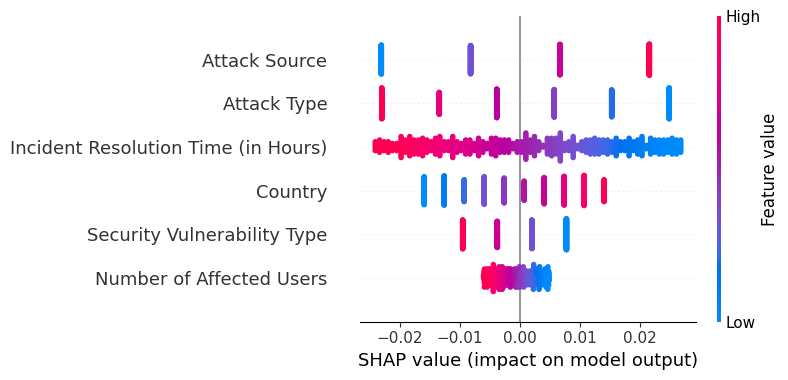

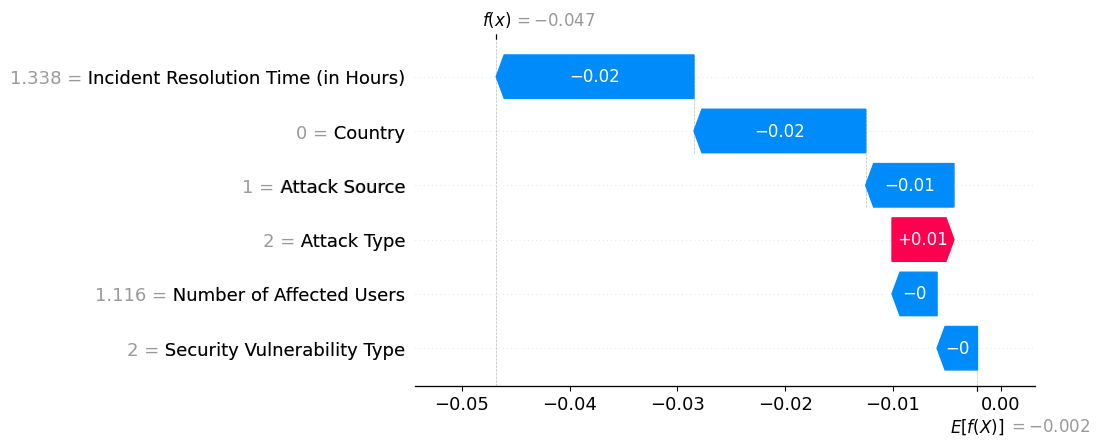

In [14]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
shap.plots.waterfall(shap_values[0])


#7 LIME Explanation


--- Explaining Specific Instances with LIME ---

📄 LIME Explanation for Instance 0 (Feature → Contribution):
Attack Source <= 1.00                    → -0.03
Incident Resolution Time (in Hours) > 0.90 → -0.03
Country <= 2.00                          → -0.02
Number of Affected Users > 0.87          → -0.01
1.00 < Security Vulnerability Type <= 2.00 → -0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


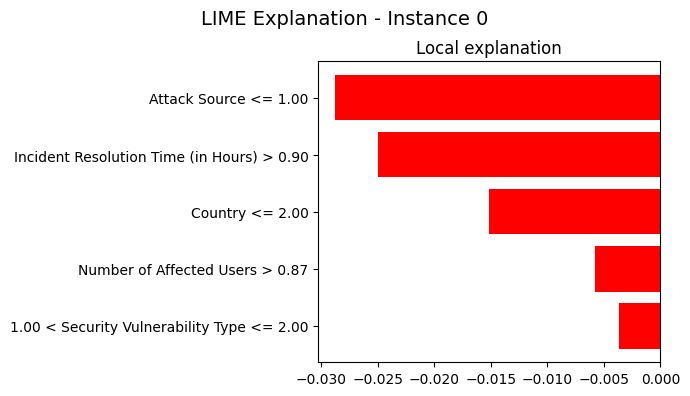


🔷 Model Predicted Financial Loss: $-0.05 Million

📄 LIME Explanation for Instance 5 (Feature → Contribution):
Attack Source <= 1.00                    → -0.03
Security Vulnerability Type <= 1.00      → +0.01
-0.85 < Incident Resolution Time (in Hours) <= 0.03 → +0.01
2.00 < Country <= 5.00                   → -0.00
-0.01 < Number of Affected Users <= 0.87 → -0.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


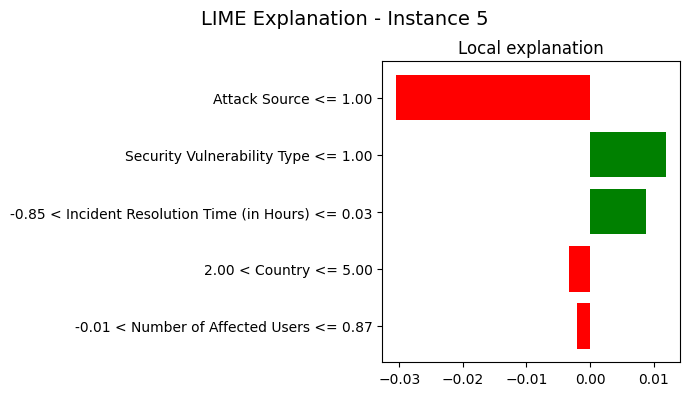


🔷 Model Predicted Financial Loss: $0.01 Million


In [15]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='regression'
)

def explain_lime_instance(instance_idx, model, X_test, explainer):
    instance = X_test.iloc[instance_idx]
    lime_exp = explainer.explain_instance(
        data_row=instance.values,
        predict_fn=model.predict,
        num_features=5
    )
    print(f"\n📄 LIME Explanation for Instance {instance_idx} (Feature → Contribution):")
    for feature, value in lime_exp.as_list():
        print(f"{feature:40} → {value:+.2f}")
    fig = lime_exp.as_pyplot_figure()
    fig.set_size_inches(7, 4)
    fig.suptitle(f"LIME Explanation - Instance {instance_idx}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    model_pred = model.predict(pd.DataFrame([instance], columns=X_test.columns))[0]
    print(f"\n🔷 Model Predicted Financial Loss: ${model_pred:.2f} Million")

print("\n--- Explaining Specific Instances with LIME ---")
explain_lime_instance(0, best_model, X_test, lime_explainer)
explain_lime_instance(5, best_model, X_test, lime_explainer)


                         NOTE FOR WARNING

The UserWarning is a common occurrence when using LIME with scikit-learn models fitted with feature names, because LIME often passes NumPy arrays without feature names to the predict_fn. It typically doesn't impact the correctness of the LIME explanations in this context. You can choose to ignore it or suppress it if the output is too noisy.

In [16]:
# Save Models & Encoders
joblib.dump(iso_model, 'isolation_forest_model.joblib')
joblib.dump(best_model, 'best_regressor_model.joblib')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')
print('Artifacts saved.')

Artifacts saved.
